## Generate a heatmap of a tv series episodes

In [1]:
# Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Input show title to find the imdb id

#Variables
show = 'Friends'
url_search = 'https://www.imdb.com/find?q='

# Set up Dataframe to create Heatmap
df = pd.DataFrame(columns=['show','season','episode','rating'])
df = df.astype({'show':'str','season':'int','episode':'int','rating':'float'})

# Put the search term in the url_search     example: imdb.com/find?q=breaking+bad
for word in show.split():
    if url_search[-1] == '=':
        url_search = url_search + word
    else:
        url_search = url_search+'+'+word
#url_search

# Parse the get request
r_search = requests.get(url_search)
soup_search = BeautifulSoup(r_search.text, 'html.parser')
#soup_search

# Get the imdb_id
results_search = soup_search.find('tr', attrs={'class':'findResult odd'})
imdb_id = results_search.find('a')['href'].split('/')[2]
show = results_search.find_all('a')[1].text
print(show,imdb_id)

Friends tt0108778


In [3]:
# Use the imdb id to find the latest season available
r_home = requests.get('https://www.imdb.com/title/'+imdb_id)
soup_home = BeautifulSoup(r_home.text, 'html.parser')
#soup_home

# find the latest season available
results_home = soup_home.find('div', attrs = {'class': 'seasons-and-year-nav'})
max_season =  int(results_home.find('a').text)
max_season

10

In [4]:
# Find the ratings for episodes in each season
for current_season in range(1,max_season+1):
    r_season = requests.get('https://www.imdb.com/title/'+imdb_id+'/episodes?season='+str(current_season))
    soup_season = BeautifulSoup(r_season.text, 'html.parser')
    #soup_season
    episode = 1
    results = soup_season.find_all('span', attrs={'class':'ipl-rating-star__rating'})[::23]     #ratings occur in every 23rd item
    for rating in results:
        #print(current_season,episode,rating.text)
        df = df.append({'show':show,
                        'season':current_season,
                        'episode':episode,
                        'rating':float(rating.text)},
                        ignore_index=True)
        episode += 1

# Num of season and episodes determine size of plot
max_season = df.season.max()    
max_episode = df.episode.max()

df     

,show,season,episode,rating
0,Friends,1,1,8.3
1,Friends,1,2,8.1
2,Friends,1,3,8.2
3,Friends,1,4,8.1
4,Friends,1,5,8.5
...,...,...,...,...
231,Friends,10,14,8.6
232,Friends,10,15,8.5
233,Friends,10,16,8.9
234,Friends,10,17,9.5


In [5]:
# Pivot Table
df_pivot = df.pivot(index='season',columns='episode',values='rating')
df_pivot

episode,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
season,,,,,,,,,,,,,,,,,,,,,
1,8.3,8.1,8.2,8.1,8.5,8.1,9.0,8.1,8.2,8.1,...,8.2,8.5,8.8,8.1,7.9,7.9,8.3,8.7,8.9,NaN
2,8.5,8.2,8.4,8.0,8.3,8.6,9.0,8.5,8.0,8.0,...,8.6,8.3,8.5,8.6,8.2,8.2,9.0,8.1,8.2,NaN
3,8.4,9.0,8.1,8.1,8.1,9.1,8.3,8.4,9.0,8.1,...,9.1,8.3,8.4,8.2,8.1,8.7,8.3,8.1,8.1,8.9
4,9.1,8.1,8.5,8.2,8.4,8.5,8.7,9.1,7.9,8.1,...,8.2,8.6,8.3,8.7,8.5,7.2,8.5,8.7,9.2,NaN
5,8.9,9.0,8.8,8.3,8.8,8.1,8.4,9.2,9.1,8.2,...,8.6,8.5,8.0,8.7,8.3,8.5,8.3,8.8,9.1,NaN
6,8.7,8.2,8.2,8.5,8.2,8.5,8.4,8.5,9.2,8.6,...,8.5,9.1,8.3,8.3,7.4,8.6,9.0,8.6,8.8,9.3
7,8.4,8.3,8.1,8.1,8.1,8.9,8.5,8.2,8.1,8.5,...,8.7,8.4,8.4,8.7,8.4,7.5,8.4,8.9,9.2,NaN
8,8.7,9.1,8.7,9.3,8.1,8.5,7.9,8.8,9.3,8.1,...,8.3,8.1,8.2,7.5,8.2,8.2,8.3,8.8,8.9,NaN
9,8.6,8.5,8.2,8.2,8.5,8.4,8.7,8.8,8.2,7.5,...,8.2,8.5,8.6,8.1,8.2,8.2,7.8,8.5,8.6,NaN


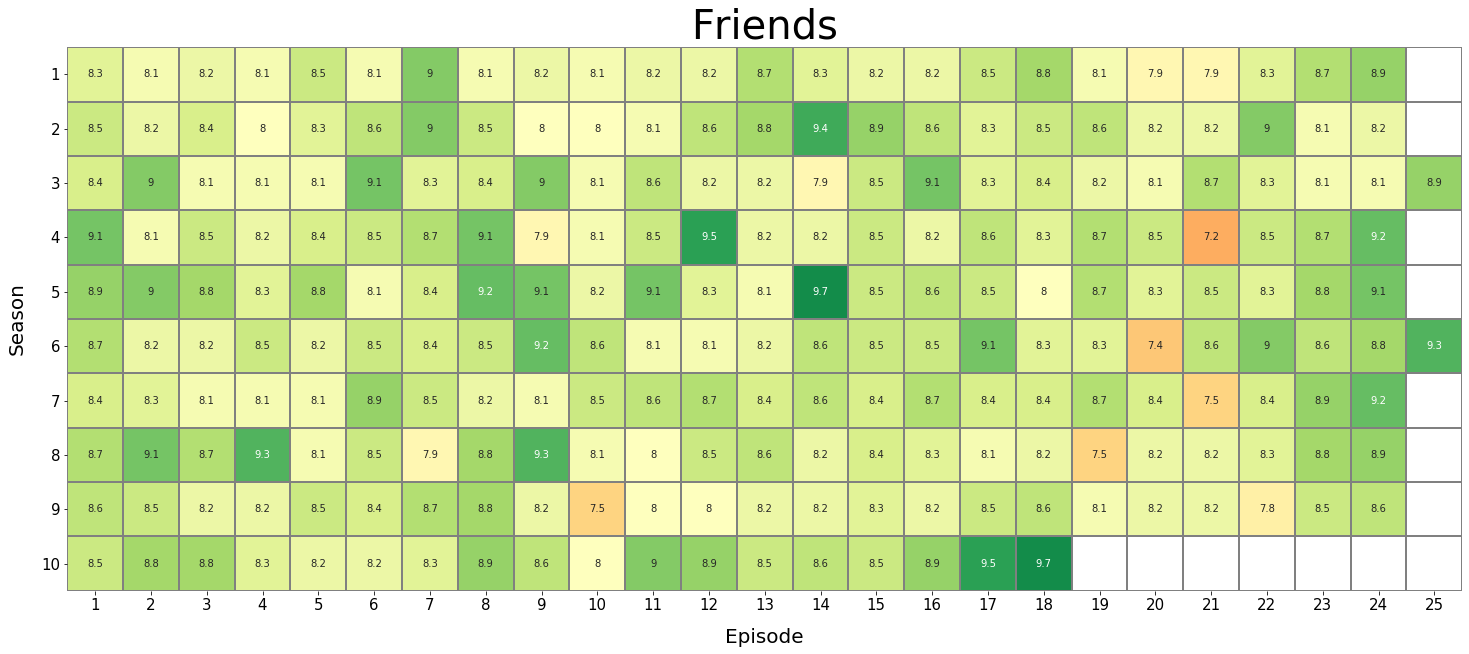

In [6]:
# Plot
f, ax = plt.subplots(figsize=(max_episode, max_season))
ax = sns.heatmap(df_pivot,vmin=6,vmax=10, annot=True,linewidths=1, cmap='RdYlGn', linecolor='gray', cbar=False)
ax.set_title(show,fontsize=40)
ax.set_xlabel('Episode',fontsize=20,labelpad=15)
ax.set_ylabel('Season',fontsize=20,labelpad=15)
ax.tick_params(labelsize=15)
plt.yticks(rotation=0)
plt.savefig(show+'.png')